In [1]:
# ========= 0. Setup device and threading =========

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Device setup: use CUDA if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)
if device.type == 'cuda':
    # enable cudnn autotuner (useful if input sizes are stable)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

# Optionally control threads for CPU-bound parts
torch.set_num_threads(8)  # uncomment and tune if CPU is the bottleneck

Using device: cuda


In [2]:
# ========= 1. 读取并解析输入 =========
# df = pd.read_csv("../pymochi_catal_nostop_dataset_weighted.tsv", sep="\t")  # 你的输入表
df = pd.read_csv("../pymochi_catal_nostop_dataset_weighted.tsv", sep="\t")
wt_seq = df.loc[df["WT"] == True, "aa_seq"].values[0]
mut_seqs = df["aa_seq"].values

# fitness = torch.tensor(df["fitness"].values, dtype=torch.float32)
fitness = torch.tensor(df["K"].values, dtype=torch.float32)
# sigma = torch.tensor(df["sigma"].values, dtype=torch.float32)
weight = torch.tensor(df["weight"].values, dtype=torch.float32)

In [3]:
# ========= 2. 找出所有突变类型 =========

# find single mutations
def find_mutations(seq, wt):
    return [(i, wt[i], seq[i]) for i in range(len(wt)) if seq[i] != wt[i]]

all_mutations = sorted(list({
    (i, wt_seq[i], s[i]) 
    for s in mut_seqs 
    for i in range(len(wt_seq)) 
    if s[i] != wt_seq[i]
}))

mut_to_idx = {m: k for k, m in enumerate(all_mutations)}
M = len(all_mutations)  # 特征数
N = len(df)

# find all mutation pairs for mutantation sequences with >1 mutation site
# e.g. for a sequence with 5 different sites, we have 10 pairs
def find_mutation_pairs(seq, wt):
    muts = find_mutations(seq, wt)
    pairs = []
    for i in range(len(muts)):
        for j in range(i + 1, len(muts)):
            pairs.append((muts[i], muts[j]))
    return pairs
all_mutation_pairs = sorted(list({
    pair
    for s in mut_seqs
    for pair in find_mutation_pairs(s, wt_seq)
}))

# remove duplicate pairs like ((0,'A','C'),(1,'G','T')) and ((1,'G','T'),(0,'A','C'))
all_mutation_pairs = [tuple(sorted(p)) for p in all_mutation_pairs]
all_mutation_pairs = sorted(list(set(all_mutation_pairs)))
pair_to_idx = {p: k for k, p in enumerate(all_mutation_pairs)}
P = len(all_mutation_pairs)  # 二阶特征数
print(f"Number of features (M) = {M}, Number of total pairwise features (P) = {P}")



Number of features (M) = 2554, Number of total pairwise features (P) = 461851


In [4]:
# ========= 3. 构造 one-hot 特征矩阵 =========

# A. single mutation features
X = torch.zeros((N, M), dtype=torch.float32)
for n, seq in enumerate(mut_seqs):
    for m in find_mutations(seq, wt_seq):
        X[n, mut_to_idx[m]] = 1.0

# B. mutation pair features - build sparse representation to avoid huge dense allocation

# ---------- Step 1: 统计每个pair的出现次数 ----------
pair_counts = Counter()
for seq in mut_seqs:
    for p in find_mutation_pairs(seq, wt_seq):
        p = tuple(sorted(p))
        pair_counts[p] += 1

# ---------- Step 2: 筛选出现次数 >= min_support 的pair ----------
min_support = 3  # 可以调整阈值，比如3或5
filtered_pairs = [p for p, c in pair_counts.items() if c >= min_support]
pair_to_idx = {p: i for i, p in enumerate(filtered_pairs)}
P = len(filtered_pairs)

print(f"Number of filtered pairs kept: {P} / {len(pair_counts)} (min_support={min_support})")

# ---------- Step 3: 构建稀疏表示 ----------
row_idx, col_idx, vals = [], [], []
for n, seq in enumerate(mut_seqs):
    for p in find_mutation_pairs(seq, wt_seq):
        p = tuple(sorted(p))
        idx = pair_to_idx.get(p)
        if idx is None:
            continue  # 被过滤掉的pair不会加入矩阵
        row_idx.append(n)
        col_idx.append(idx)
        vals.append(1.0)

# ---------- Step 4: 转成稀疏张量 ----------
if len(row_idx) == 0:
    X_pair = torch.zeros((N, 0), dtype=torch.float32)
else:
    indices = torch.tensor([row_idx, col_idx], dtype=torch.long)
    values = torch.tensor(vals, dtype=torch.float32)
    X_pair = torch.sparse_coo_tensor(indices, values, size=(N, P))
    X_pair = X_pair.coalesce()
    print(f"Constructed sparse X_pair with nnz={X_pair._nnz()}")

# print(f"N={N}, P={P}")
# row_idx = []
# col_idx = []
# vals = []
# for n, seq in enumerate(mut_seqs):
#     for p in find_mutation_pairs(seq, wt_seq):
#         p = tuple(sorted(p))
#         idx = pair_to_idx.get(p)
#         if idx is None:
#             continue
#         row_idx.append(n)
#         col_idx.append(idx)
#         vals.append(1.0)

# # convert to tensors
# if len(row_idx) == 0:
#     # fallback to a small dense tensor if no pairs exist
#     X_pair = torch.zeros((N, 0), dtype=torch.float32)
# else:
#     indices = torch.tensor([row_idx, col_idx], dtype=torch.long)  # shape (2, nnz)
#     values = torch.tensor(vals, dtype=torch.float32)
#     X_pair = torch.sparse_coo_tensor(indices, values, size=(N, P))  # sparse tensor (N, P)
#     X_pair = X_pair.coalesce()  # ensure unique indices
#     print(f"Constructed sparse X_pair with nnz={X_pair._nnz()}")

# Move tensors to device (dense tensors to device; sparse move supported in newer torch)
X = X.to(device)
try:
    X_pair = X_pair.to(device)
except Exception as e:
    print("Warning: could not move sparse X_pair to device:", e)
    # keep X_pair on CPU; sparse CUDA support may depend on PyTorch build

fitness = fitness.to(device)
weight = weight.to(device)
# check X
print(X.shape)  # (N, M)
print(X.sum(dim=1))
print(X.sum(dim=0))  # check feature distribution
print(X[0])  # first row
print(X[:, 0])  # first column

# check X_pair
print(X_pair.shape)  # (N, P)

Number of filtered pairs kept: 99506 / 461851 (min_support=3)
Constructed sparse X_pair with nnz=409549
torch.Size([113470, 2554])
tensor([1., 4., 2.,  ..., 2., 2., 3.], device='cuda:0')
tensor([128.,  20.,  87.,  ..., 109., 689.,  17.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
torch.Size([113470, 99506])


In [5]:
# ========= 4. 定义模型 =========
class MoCHI_Core(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(n_features))  # additive coefficients
        self.phi0 = nn.Parameter(torch.tensor(0.0))
        self.g = nn.Sequential(  # global epistasis (sum of sigmoids)
            nn.Linear(1, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1)
        )
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))

    def forward(self, X):
        phi = self.phi0 + X @ self.theta
        p = self.g(phi.unsqueeze(1)).squeeze(1)
        yhat = self.a * p + self.b
        return yhat, phi

class MoCHI_TwoState_order1(nn.Module):
    def __init__(self, M, R=8.314, T=303.0):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(M))
        self.phi0 = nn.Parameter(torch.tensor(0.0))
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        self.R = R
        self.T = T

    def forward(self, X):
        phi = self.phi0 + X @ self.theta             # (N,)
        z = torch.clamp(phi / (self.R * self.T), -50, 50)
        p = 1.0 / (1.0 + torch.exp(z))
        yhat = self.a * p + self.b
        return yhat, phi

class MoCHI_TwoState_order2(nn.Module):
    def __init__(self, M, P, R=8.314, T=303.0):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(M))
        self.phi0 = nn.Parameter(torch.tensor(0.0))
        self.phi_pair = nn.Parameter(torch.zeros(P))
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        self.R = R
        self.T = T

    def forward(self, X, X_pair):
        # Accept dense or sparse X_pair. If sparse, use efficient sparse mm
        phi = self.phi0 + X @ self.theta
        if getattr(X_pair, 'is_sparse', False):
            phi_pair_vec = self.phi_pair.unsqueeze(1)  # (P,1)
            # Sparse operations don't support autocast, so we need to disable it temporarily
            if torch.is_autocast_enabled():
                with torch.amp.autocast(device_type='cuda', enabled=False):
                    pair_term = torch.sparse.mm(X_pair, phi_pair_vec).squeeze(1)
            else:
                pair_term = torch.sparse.mm(X_pair, phi_pair_vec).squeeze(1)
        else:
            pair_term = X_pair @ self.phi_pair
        phi = phi + pair_term  # (N,)
        z = torch.clamp(phi / (self.R * self.T), -50, 50)
        p = 1.0 / (1.0 + torch.exp(z))
        yhat = self.a * p + self.b
        return yhat, phi


class Linear_order2(nn.Module):
    """
    线性模型：yhat = phi0 + X @ theta + X_pair @ phi_pair
    """
    def __init__(self, M, P):
        super().__init__()
        self.phi0 = nn.Parameter(torch.zeros(1))
        self.theta = nn.Parameter(torch.zeros(M))
        self.phi_pair = nn.Parameter(torch.zeros(P))

    def forward(self, X, X_pair):
        # 简单的线性预测：yhat = phi0 + X @ theta + X_pair @ phi_pair
        yhat = self.phi0 + X @ self.theta
        
        if getattr(X_pair, 'is_sparse', False):
            phi_pair_vec = self.phi_pair.unsqueeze(1)
            if torch.is_autocast_enabled():
                with torch.amp.autocast(device_type='cuda', enabled=False):
                    pair_term = torch.sparse.mm(X_pair, phi_pair_vec).squeeze(1)
            else:
                pair_term = torch.sparse.mm(X_pair, phi_pair_vec).squeeze(1)
        else:
            pair_term = X_pair @ self.phi_pair
        
        yhat = yhat + pair_term
        return yhat


class Linear_order1(nn.Module):
    """
    仅使用单突变的线性模型：yhat = phi0 + X @ theta
    用 LASSO 在单突变特征上求解稀疏 theta (不包含 pairwise)
    """
    def __init__(self, M):
        super().__init__()
        self.phi0 = nn.Parameter(torch.zeros(1))
        self.theta = nn.Parameter(torch.zeros(M))

    def forward(self, X):
        yhat = self.phi0 + X @ self.theta
        return yhat


# instantiate and move models to device
model1 = MoCHI_TwoState_order1(M).to(device)
model2 = MoCHI_TwoState_order2(M, P).to(device)
model_linear = Linear_order2(M, P).to(device)
# new: linear model using only single-mutation features
model_linear1 = Linear_order1(M).to(device)


In [6]:
# ========= 4.5 线性模型求解（LASSO）=========
# 对于 Linear_order2 模型，可以用LASSO直接求解，无需迭代优化

from sklearn.linear_model import Lasso
from scipy.sparse import csr_matrix, hstack
import numpy as np

print("\n" + "=" * 60)
print("Linear Model (Linear_order2) - LASSO Solution")
print("=" * 60)

# 转换为 sparse 格式（不转 dense！）
X_np = X.cpu().numpy()  # (N, M)
X_np_sparse = csr_matrix(X_np)  # 转为 sparse format

# 处理稀疏矩阵（可能在GPU或CPU上）
# ⚠️ 关键：保持 sparse format，不转 dense！
if getattr(X_pair, 'is_sparse', False):
    # 从 PyTorch sparse tensor 提取数据，构建 scipy sparse
    X_pair_cpu = X_pair.cpu()
    indices = X_pair_cpu._indices().numpy()
    values = X_pair_cpu._values().numpy()
    shape = X_pair_cpu.shape
    X_pair_sparse = csr_matrix((values, (indices[0], indices[1])), shape=shape)
    print(f"  Built sparse X_pair with shape {shape}, nnz={len(values)}")
else:
    X_pair_sparse = csr_matrix(X_pair.cpu().numpy())

fitness_np = fitness.cpu().numpy()  # (N,)
weight_np = weight.cpu().numpy()  # (N,)

print(f"\nFeature dimensions:")
print(f"  X shape: {X_np.shape} (single mutations)")
print(f"  X_pair shape: {X_pair_sparse.shape} (pairwise interactions)")
print(f"  Combined features: {X_np.shape[1] + X_pair_sparse.shape[1] + 1} (including phi0)")

# 组合特征矩阵：[ones | X | X_pair]，保持 sparse 格式
ones = csr_matrix(np.ones((N, 1)))
X_combined = hstack([ones, X_np_sparse, X_pair_sparse])  # 保持 sparse

# ⚠️ 改进：不在fit中应用加权，而是在loss计算中应用加权
# 这样可以避免过度正则化导致参数全变零
print(f"  Feature matrix (unweighted): {X_combined.shape} (sparse)")

# 尝试多个 alpha 值 - 需要更小的alpha以避免过度正则化
alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
lasso_results = {}

print(f"\nTraining LASSO with different alpha values...\n")

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-6, fit_intercept=False)
    # 在原始（未加权）数据上fit
    lasso.fit(X_combined, fitness_np)
    coef = lasso.coef_
    
    # 提取参数
    phi0_sol = coef[0]
    theta_sol = coef[1:1+M]
    phi_pair_sol = coef[1+M:1+M+P]
    
    # 计算预测和加权损失
    yhat_linear = phi0_sol + X_np @ theta_sol + X_pair_sparse.dot(phi_pair_sol)
    residual = fitness_np - yhat_linear
    # 加权损失
    weighted_mae = np.mean(np.abs(residual * weight_np))
    
    # 计算稀疏度
    nnz_theta = np.count_nonzero(np.abs(theta_sol) > 1e-10)
    nnz_phi_pair = np.count_nonzero(np.abs(phi_pair_sol) > 1e-10)
    sparsity_phi_pair = 100 * (1 - nnz_phi_pair / len(phi_pair_sol))
    
    # 计算 L1 范数
    l1_theta = np.sum(np.abs(theta_sol))
    l1_phi_pair = np.sum(np.abs(phi_pair_sol))
    
    lasso_results[alpha] = {
        'phi0': phi0_sol,
        'theta': theta_sol,
        'phi_pair': phi_pair_sol,
        'loss': weighted_mae,
        'nnz_theta': nnz_theta,
        'nnz_phi_pair': nnz_phi_pair,
        'sparsity_phi_pair': sparsity_phi_pair,
        'l1_theta': l1_theta,
        'l1_phi_pair': l1_phi_pair
    }
    
    print(f"alpha = {alpha:8.2e} | Loss = {weighted_mae:.6f} | " +
          f"NNZ(theta)={nnz_theta:4d} | NNZ(phi_pair)={nnz_phi_pair:5d} | " +
          f"Sparsity={sparsity_phi_pair:5.1f}%")

# 找到损失最小的模型
best_alpha = min(lasso_results.keys(), key=lambda a: lasso_results[a]['loss'])
best_result = lasso_results[best_alpha]

print(f"\n{'='*60}")
print(f"Best LASSO solution: alpha = {best_alpha}")
print(f"{'='*60}")
print(f"Loss (Weighted MAE): {best_result['loss']:.6f}")
print(f"Parameters:")
print(f"  phi0: {best_result['phi0']:.6f}")
print(f"  theta: NNZ={best_result['nnz_theta']}, ||theta||_1={best_result['l1_theta']:.4f}")
print(f"  phi_pair: NNZ={best_result['nnz_phi_pair']}, Sparsity={best_result['sparsity_phi_pair']:.2f}%, " +
      f"||phi_pair||_1={best_result['l1_phi_pair']:.4f}")
print(f"{'='*60}")

# 将最佳参数加载到模型
with torch.no_grad():
    model_linear.phi0.data = torch.tensor([best_result['phi0']], dtype=torch.float32, device=device)
    model_linear.theta.data = torch.tensor(best_result['theta'], dtype=torch.float32, device=device)
    model_linear.phi_pair.data = torch.tensor(best_result['phi_pair'], dtype=torch.float32, device=device)

print("\n✓ LASSO parameters loaded to model_linear")

# ========= 4.6b 线性模型（单突变）求解 - Linear_order1 (LASSO) =========
print('\n' + '='*60)
print('Linear Model (Linear_order1) - LASSO Solution (single mutations only)')
print('='*60)

X_single_sparse = X_np_sparse  # csr_matrix of shape (N, M)
X1_combined = hstack([ones, X_single_sparse])

lasso1_results = {}
print('\nTraining LASSO (single-mutation only) with different alpha values...\n')

for alpha in alphas:
    lasso1 = Lasso(alpha=alpha, max_iter=10000, tol=1e-6, fit_intercept=False)
    # 在原始数据上fit（不加权）
    lasso1.fit(X1_combined, fitness_np)
    coef1 = lasso1.coef_
    phi01 = coef1[0]
    theta1 = coef1[1:1+M]
    
    # 计算加权损失
    yhat1 = phi01 + X_np @ theta1
    residual1 = fitness_np - yhat1
    weighted_mae1 = np.mean(np.abs(residual1 * weight_np))
    
    nnz_theta1 = np.count_nonzero(np.abs(theta1) > 1e-10)
    l1_theta1 = np.sum(np.abs(theta1))
    lasso1_results[alpha] = { 'phi0': phi01, 'theta': theta1, 'loss': weighted_mae1, 'nnz_theta': nnz_theta1, 'l1_theta': l1_theta1 }
    print(f"alpha = {alpha:8.2e} | Loss = {weighted_mae1:.6f} | NNZ(theta)={nnz_theta1:4d}")

# choose best
best_alpha1 = min(lasso1_results.keys(), key=lambda a: lasso1_results[a]['loss'])
best_result1 = lasso1_results[best_alpha1]

print('\n' + '='*60)
print(f'Best LASSO (single) alpha = {best_alpha1}')
print(f"Loss (Weighted MAE): {best_result1['loss']:.6f}")
print('\nLoading parameters into model_linear1...')

with torch.no_grad():
    model_linear1.phi0.data = torch.tensor([best_result1['phi0']], dtype=torch.float32, device=device)
    model_linear1.theta.data = torch.tensor(best_result1['theta'], dtype=torch.float32, device=device)

print('\n✓ LASSO (single) parameters loaded to model_linear1')



Linear Model (Linear_order2) - LASSO Solution
  Built sparse X_pair with shape torch.Size([113470, 99506]), nnz=409549

Feature dimensions:
  X shape: (113470, 2554) (single mutations)
  X_pair shape: (113470, 99506) (pairwise interactions)
  Combined features: 102061 (including phi0)
  Feature matrix (unweighted): (113470, 102061) (sparse)

Training LASSO with different alpha values...



/home/ding_linux/anaconda3/envs/pymochi/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1085.1367745337384, tolerance: 0.1416875411029568
  model = cd_fast.sparse_enet_coordinate_descent(


alpha = 1.00e-08 | Loss = 0.111108 | NNZ(theta)=2412 | NNZ(phi_pair)=90304 | Sparsity=  9.2%


/home/ding_linux/anaconda3/envs/pymochi/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.114585654817347, tolerance: 0.1416875411029568
  model = cd_fast.sparse_enet_coordinate_descent(


alpha = 1.00e-07 | Loss = 0.126652 | NNZ(theta)=2353 | NNZ(phi_pair)=83560 | Sparsity= 16.0%
alpha = 1.00e-06 | Loss = 0.207694 | NNZ(theta)=2175 | NNZ(phi_pair)=70990 | Sparsity= 28.7%
alpha = 1.00e-05 | Loss = 0.415043 | NNZ(theta)=1640 | NNZ(phi_pair)=28894 | Sparsity= 71.0%
alpha = 1.00e-04 | Loss = 0.566991 | NNZ(theta)= 884 | NNZ(phi_pair)=    1 | Sparsity=100.0%
alpha = 1.00e-03 | Loss = 0.595903 | NNZ(theta)=  57 | NNZ(phi_pair)=    0 | Sparsity=100.0%
alpha = 1.00e-02 | Loss = 0.598920 | NNZ(theta)=   0 | NNZ(phi_pair)=    0 | Sparsity=100.0%

Best LASSO solution: alpha = 1e-08
Loss (Weighted MAE): 0.111108
Parameters:
  phi0: -0.209834
  theta: NNZ=2412, ||theta||_1=1132.4468
  phi_pair: NNZ=90304, Sparsity=9.25%, ||phi_pair||_1=88818.1439

✓ LASSO parameters loaded to model_linear

Linear Model (Linear_order1) - LASSO Solution (single mutations only)

Training LASSO (single-mutation only) with different alpha values...

alpha = 1.00e-08 | Loss = 0.556120 | NNZ(theta)=2551
al

In [7]:
# ========= 5. 训练设置 =========

optimizer1 = optim.Adam(params=model1.parameters(), lr=0.05)
optimizer2 = optim.Adam(params=model2.parameters(), lr=0.05)

lambda_l1 = 1e-8  # L1 penalty factor for phi_pair
n_epochs = 30000

# Early stopping parameters
patience = 500
min_delta = 1e-5
best_loss = float('inf')
patience_counter = 0
stopped_early = False

# Setup mixed precision training if using CUDA
use_amp = (device.type == 'cuda')
scaler1 = torch.amp.GradScaler('cuda') if use_amp else None
scaler2 = torch.amp.GradScaler('cuda') if use_amp else None

# Initialize loss history tracking
loss_history1 = []
loss_history2 = []
data_loss_history = []
l1_loss_history = []
epoch_list = []

# ========= Order 1 Training =========
print("=" * 60)
print("Training Order 1 Model (Single Mutations Only)")
print("=" * 60)

best_loss1 = float('inf')
patience_counter1 = 0

for epoch in range(n_epochs):
    optimizer1.zero_grad()
    
    # Mixed precision forward pass
    if use_amp:
        with torch.amp.autocast('cuda'):
            yhat, phi = model1(X)
            loss = torch.mean(torch.abs((fitness - yhat) * weight))
        # Scaled backward pass
        scaler1.scale(loss).backward()
        scaler1.step(optimizer1)
        scaler1.update()
    else:
        yhat, phi = model1(X)
        loss = torch.mean(torch.abs((fitness - yhat) * weight))
        loss.backward()
        optimizer1.step()
    
    # Record loss every 10 epochs
    if epoch % 10 == 0:
        loss_history1.append(loss.item())
        if epoch == 0:
            epoch_list.append(epoch)
    
    # Early stopping check
    current_loss = loss.item()
    if current_loss < best_loss1 * (1 - min_delta):
        best_loss1 = current_loss
        patience_counter1 = 0
    else:
        patience_counter1 += 1
    
    if epoch % 500 == 0:
        phi_range = f"[{phi.min().item():.2f}, {phi.max().item():.2f}]"
        print(f"Epoch {epoch:4d} | Loss = {loss.item():.5f} | phi_range = {phi_range} | patience = {patience_counter1}/{patience}")
    
    if patience_counter1 >= patience:
        print(f"\n>>> Early stopping triggered at epoch {epoch}")
        print(f">>> Best loss: {best_loss1:.5f}, Current loss: {current_loss:.5f}")
        break

print("\n" + "=" * 60)
print("Training Order 2 Model (Single Mutations + Pairs)")
print(f"L1 regularization: lambda_l1={lambda_l1}")
print("=" * 60)

# ========= Order 2 Training =========
for epoch in range(n_epochs):
    optimizer2.zero_grad()
    
    # Mixed precision forward pass
    if use_amp:
        with torch.amp.autocast('cuda'):
            yhat, phi = model2(X, X_pair)
            data_loss = torch.mean(torch.abs((fitness - yhat) * weight))
            l1_penalty = lambda_l1 * torch.norm(model2.phi_pair, p=1)
            loss = data_loss + l1_penalty
        # Scaled backward pass
        scaler2.scale(loss).backward()
        scaler2.step(optimizer2)
        scaler2.update()
    else:
        yhat, phi = model2(X, X_pair)
        data_loss = torch.mean(torch.abs((fitness - yhat) * weight))
        l1_penalty = lambda_l1 * torch.norm(model2.phi_pair, p=1)
        loss = data_loss + l1_penalty
        loss.backward()
        optimizer2.step()
    
    # Record loss every 10 epochs
    if epoch % 10 == 0:
        loss_history2.append(loss.item())
        data_loss_history.append(data_loss.item())
        l1_loss_history.append(l1_penalty.item())
        if len(epoch_list) < len(loss_history2):
            epoch_list.append(epoch)
    
    # Early stopping based on data_loss only
    current_data_loss = data_loss.item()
    if current_data_loss < best_loss * (1 - min_delta):
        best_loss = current_data_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 500 == 0:
        phi_pair_norm = torch.norm(model2.phi_pair, p=1).item()
        nnz_phi_pair = int((torch.abs(model2.phi_pair) > 1e-10).sum().item())
        sparsity_pct = 100.0 * (1.0 - nnz_phi_pair / model2.phi_pair.numel())
        print(f"Epoch {epoch:4d} | Total={loss.item():.5f} | Data={data_loss.item():.5f} | L1={l1_penalty.item():.5f}")
        print(f"              ||phi_pair||_1={phi_pair_norm:.4f} | NNZ={nnz_phi_pair} | Sparsity={sparsity_pct:.1f}% | patience={patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print(f"\n{'='*60}")
        print(f">>> Early stopping triggered at epoch {epoch}")
        print(f">>> Best data loss: {best_loss:.5f}, Current: {current_data_loss:.5f}")
        print(f">>> No improvement for {patience} consecutive epochs")
        print(f"{'='*60}")
        stopped_early = True
        break

print("\n" + "=" * 60)
if stopped_early:
    print(f"Training stopped early at epoch {epoch}/{n_epochs}")
else:
    print("Training completed all epochs!")
print(f"Final data loss: {data_loss.item():.5f}")
print(f"Final L1 penalty: {l1_penalty.item():.5f}")
print(f"Final total loss: {loss.item():.5f}")

# Final sparsity analysis
final_nnz = int((torch.abs(model2.phi_pair) > 1e-10).sum().item())
final_sparsity = 100.0 * (1.0 - final_nnz / model2.phi_pair.numel())
print(f"Final phi_pair non-zeros: {final_nnz} / {model2.phi_pair.numel()} ({final_sparsity:.2f}% sparse)")
print("=" * 60)

Training Order 1 Model (Single Mutations Only)
Epoch    0 | Loss = 1.13620 | phi_range = [0.00, 0.00] | patience = 0/500
Epoch  500 | Loss = 0.55061 | phi_range = [-25.84, 109.88] | patience = 3/500
Epoch 1000 | Loss = 0.55017 | phi_range = [-81.44, 288.75] | patience = 0/500
Epoch 1500 | Loss = 0.54830 | phi_range = [-174.50, 579.50] | patience = 0/500
Epoch 2000 | Loss = 0.54260 | phi_range = [-302.75, 974.50] | patience = 0/500
Epoch 2500 | Loss = 0.53510 | phi_range = [-395.25, 1310.00] | patience = 0/500
Epoch 3000 | Loss = 0.53072 | phi_range = [-386.00, 1524.00] | patience = 1/500
Epoch 3500 | Loss = 0.52871 | phi_range = [-333.25, 1658.00] | patience = 1/500
Epoch 4000 | Loss = 0.52768 | phi_range = [-342.00, 1726.00] | patience = 3/500
Epoch 4500 | Loss = 0.52709 | phi_range = [-330.25, 1759.00] | patience = 5/500
Epoch 5000 | Loss = 0.52670 | phi_range = [-321.00, 1785.00] | patience = 11/500
Epoch 5500 | Loss = 0.52640 | phi_range = [-314.75, 1786.00] | patience = 7/500
Epoc

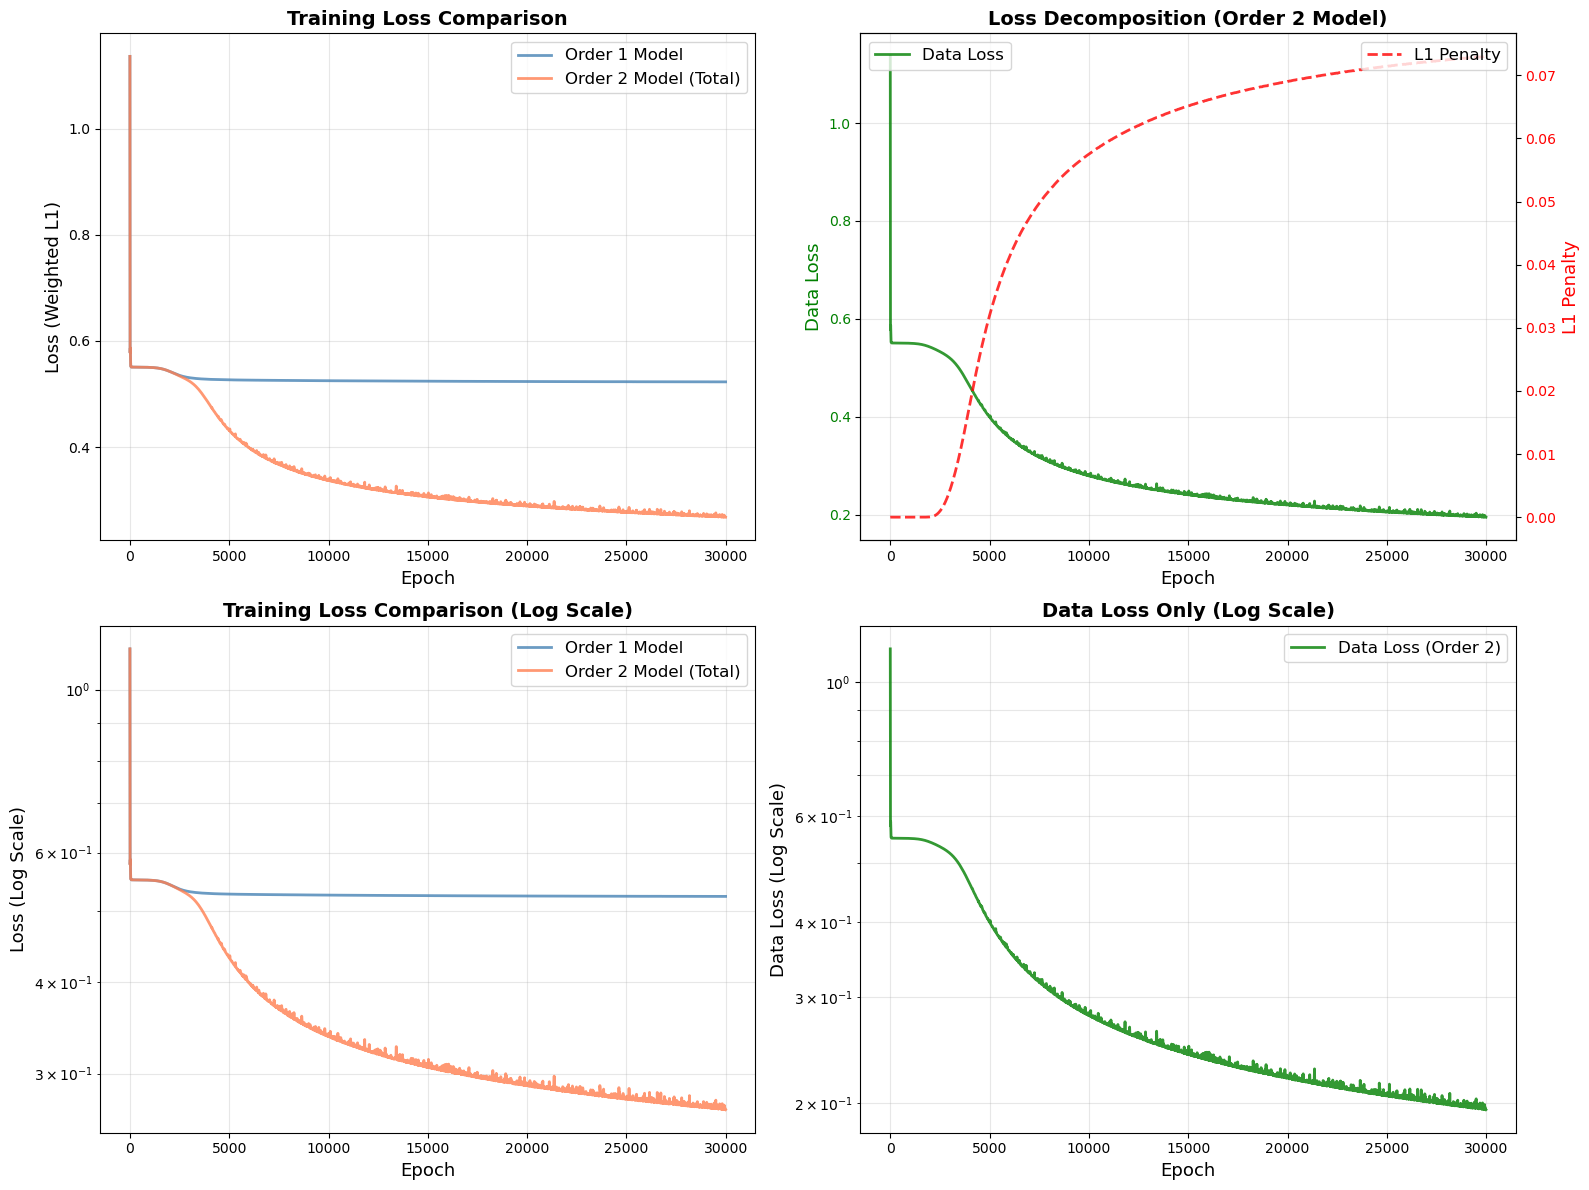

Training Summary:

Order 1 Model:
  Total epochs trained: 30000
  Initial loss: 1.13620
  Final loss: 0.52289
  Loss reduction: 0.61331 (53.98%)

Order 2 Model:
  Total epochs trained: 30000
  Initial total loss: 1.13620
  Final total loss: 0.26792
  Total loss reduction: 0.86828 (76.42%)

  Initial data loss: 1.13620
  Final data loss: 0.19491
  Data loss reduction: 0.94128 (82.85%)

  Initial L1 penalty: 0.00000
  Final L1 penalty: 0.07301
  L1 penalty change: 0.07301

Final loss comparison:
  Order 2 vs Order 1: -0.25497 (-48.76%)


In [8]:
# ========= 5.5 训练过程可视化 =========
import matplotlib.pyplot as plt

# Create epoch lists for each model based on actual recorded losses
epoch_list1 = list(range(0, len(loss_history1) * 10, 10)) if loss_history1 else []
epoch_list2 = list(range(0, len(loss_history2) * 10, 10))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total loss curves comparison
ax1 = axes[0, 0]
if loss_history1:
    ax1.plot(epoch_list1, loss_history1, linewidth=2, color='steelblue', label='Order 1 Model', alpha=0.8)
ax1.plot(epoch_list2, loss_history2, linewidth=2, color='coral', label='Order 2 Model (Total)', alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=13)
ax1.set_ylabel('Loss (Weighted L1)', fontsize=13)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(alpha=0.3)

# Plot 2: Data loss vs L1 penalty decomposition
ax2 = axes[0, 1]
# 必须使用对应的长度，不能假设 epoch_list2 和 data_loss_history 长度相同
if data_loss_history and l1_loss_history:
    ax2.plot(epoch_list2[:len(data_loss_history)], data_loss_history, linewidth=2, color='green', label='Data Loss', alpha=0.8)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(epoch_list2[:len(l1_loss_history)], l1_loss_history, linewidth=2, color='red', label='L1 Penalty', alpha=0.8, linestyle='--')
    ax2.set_xlabel('Epoch', fontsize=13)
    ax2.set_ylabel('Data Loss', fontsize=13, color='green')
    ax2_twin.set_ylabel('L1 Penalty', fontsize=13, color='red')
    ax2.set_title('Loss Decomposition (Order 2 Model)', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper left', fontsize=12)
    ax2_twin.legend(loc='upper right', fontsize=12)
    ax2.grid(alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Data loss history not available\n(training cell needs to complete)', 
            ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Loss Decomposition (Order 2 Model)', fontsize=14, fontweight='bold')

# Plot 3: Log scale for total loss
ax3 = axes[1, 0]
if loss_history1:
    ax3.semilogy(epoch_list1, loss_history1, linewidth=2, color='steelblue', label='Order 1 Model', alpha=0.8)
ax3.semilogy(epoch_list2, loss_history2, linewidth=2, color='coral', label='Order 2 Model (Total)', alpha=0.8)
ax3.set_xlabel('Epoch', fontsize=13)
ax3.set_ylabel('Loss (Log Scale)', fontsize=13)
ax3.set_title('Training Loss Comparison (Log Scale)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=12)
ax3.grid(alpha=0.3, which='both')

# Plot 4: Data loss in log scale
ax4 = axes[1, 1]
ax4.semilogy(epoch_list2[:len(data_loss_history)], data_loss_history, linewidth=2, color='green', label='Data Loss (Order 2)', alpha=0.8)
ax4.set_xlabel('Epoch', fontsize=13)
ax4.set_ylabel('Data Loss (Log Scale)', fontsize=13)
ax4.set_title('Data Loss Only (Log Scale)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=12)
ax4.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print training summary
print("=" * 60)
print("Training Summary:")
print("=" * 60)
if loss_history1:
    print(f"\nOrder 1 Model:")
    print(f"  Total epochs trained: {len(loss_history1) * 10}")
    print(f"  Initial loss: {loss_history1[0]:.5f}")
    print(f"  Final loss: {loss_history1[-1]:.5f}")
    print(f"  Loss reduction: {loss_history1[0] - loss_history1[-1]:.5f} ({(loss_history1[0] - loss_history1[-1])/loss_history1[0]*100:.2f}%)")
print(f"\nOrder 2 Model:")
print(f"  Total epochs trained: {len(loss_history2) * 10}")
print(f"  Initial total loss: {loss_history2[0]:.5f}")
print(f"  Final total loss: {loss_history2[-1]:.5f}")
print(f"  Total loss reduction: {loss_history2[0] - loss_history2[-1]:.5f} ({(loss_history2[0] - loss_history2[-1])/loss_history2[0]*100:.2f}%)")
print(f"\n  Initial data loss: {data_loss_history[0]:.5f}")
print(f"  Final data loss: {data_loss_history[-1]:.5f}")
print(f"  Data loss reduction: {data_loss_history[0] - data_loss_history[-1]:.5f} ({(data_loss_history[0] - data_loss_history[-1])/data_loss_history[0]*100:.2f}%)")
print(f"\n  Initial L1 penalty: {l1_loss_history[0]:.5f}")
print(f"  Final L1 penalty: {l1_loss_history[-1]:.5f}")
print(f"  L1 penalty change: {l1_loss_history[-1] - l1_loss_history[0]:.5f}")
if loss_history1:
    print(f"\nFinal loss comparison:")
    print(f"  Order 2 vs Order 1: {loss_history2[-1] - loss_history1[-1]:.5f} ({(loss_history2[-1] - loss_history1[-1])/loss_history1[-1]*100:.2f}%)")
print("=" * 60)

Model Parameters Summary:
phi0 (baseline): 29.8026
a (scaling): 37.3049
b (offset): -18.6883

Single mutation parameters (theta):
  - Number of features: 2554
  - Range: [-759.8807, 801.9547]
  - Mean: 31.6916, Std: 120.1633
  - Non-zero count: 2554

Mutation pair parameters (phi_pair):
  - Number of features: 99506
  - Range: [-626.6547, 655.9713]
  - Mean: -1.6776, Std: 107.6603
  - Non-zero count: 99506


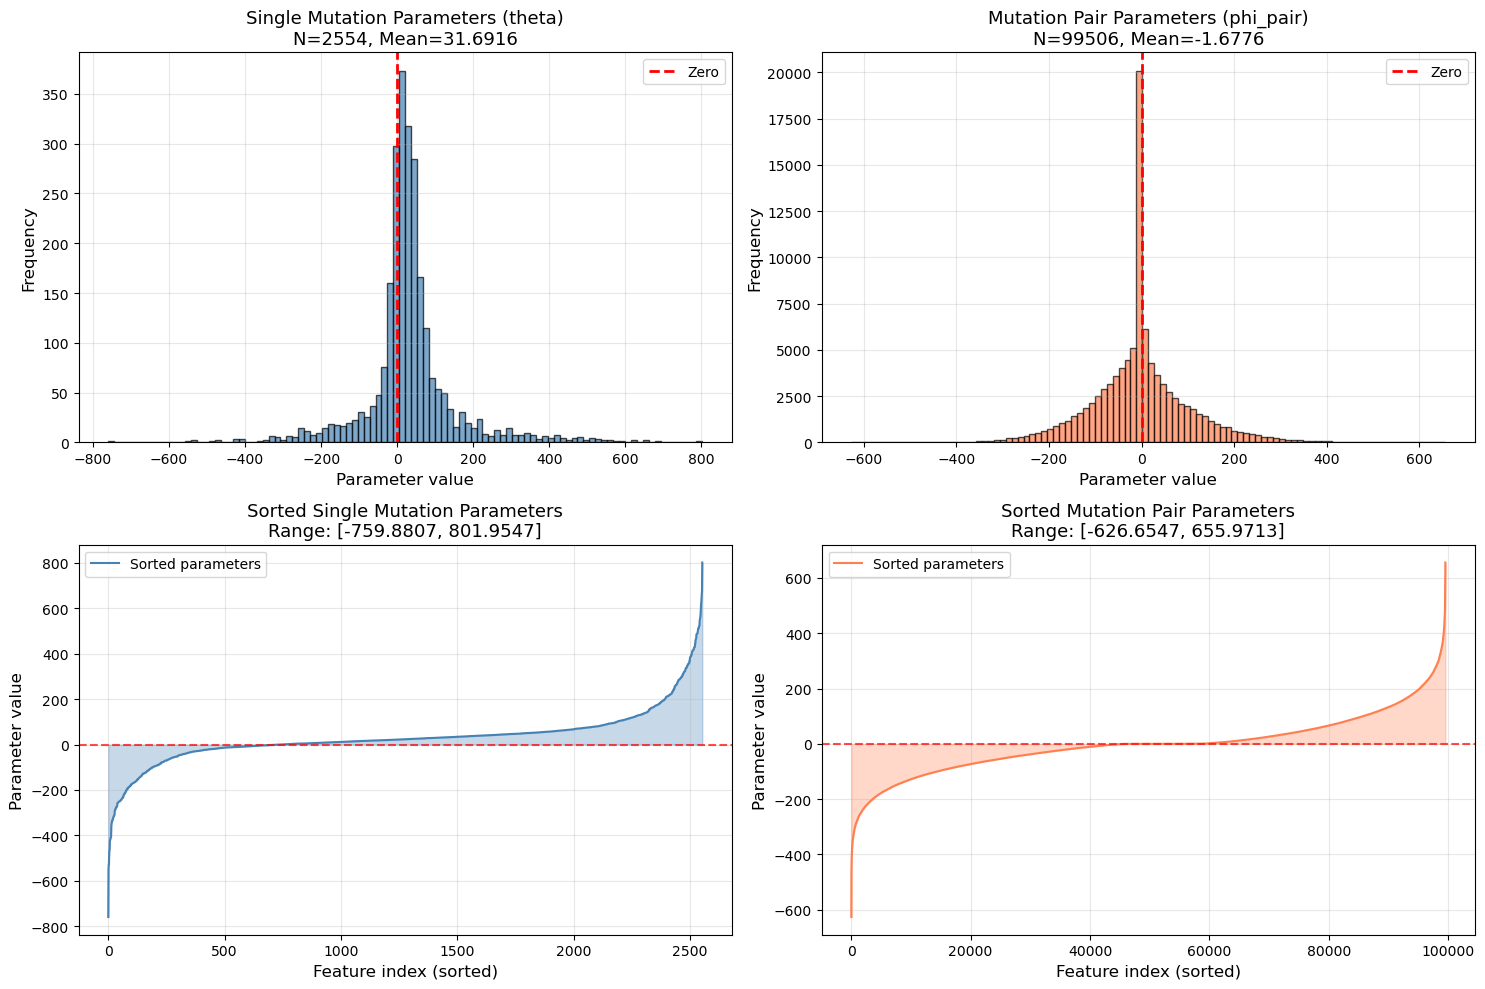


Top 10 most positive single mutations (theta):
  1. Position 36: Q->T, theta=801.9547
  2. Position 96: Q->V, theta=677.1561
  3. Position 139: I->P, theta=661.1547
  4. Position 49: N->E, theta=648.1149
  5. Position 81: V->T, theta=626.8250
  6. Position 251: K->V, theta=618.6906
  7. Position 78: L->Y, theta=594.2653
  8. Position 239: S->I, theta=579.8967
  9. Position 186: T->E, theta=564.5866
  10. Position 23: H->S, theta=557.3115

Top 10 most negative single mutations (theta):
  1. Position 234: A->S, theta=-759.8807
  2. Position 48: L->A, theta=-551.3314
  3. Position 157: T->D, theta=-528.6850
  4. Position 182: A->L, theta=-527.9454
  5. Position 28: V->Q, theta=-483.4453
  6. Position 272: R->L, theta=-465.6394
  7. Position 190: L->A, theta=-463.7040
  8. Position 258: I->A, theta=-424.6516
  9. Position 242: I->Y, theta=-420.4869
  10. Position 37: L->P, theta=-418.3093

Top 10 most positive mutation pairs (phi_pair):
  1. (26, 'T', 'K') & (176, 'D', 'E'), phi_pair=655.

In [9]:
# ========= 7. 模型参数分布分析 =========


# Extract parameters from model2
theta_values = model2.theta.detach().cpu().numpy()
phi_pair_values = model2.phi_pair.detach().cpu().numpy()
phi0_value = model2.phi0.item()
a_value = model2.a.item()
b_value = model2.b.item()

print("=" * 60)
print("Model Parameters Summary:")
print("=" * 60)
print(f"phi0 (baseline): {phi0_value:.4f}")
print(f"a (scaling): {a_value:.4f}")
print(f"b (offset): {b_value:.4f}")
print(f"\nSingle mutation parameters (theta):")
print(f"  - Number of features: {len(theta_values)}")
print(f"  - Range: [{theta_values.min():.4f}, {theta_values.max():.4f}]")
print(f"  - Mean: {theta_values.mean():.4f}, Std: {theta_values.std():.4f}")
print(f"  - Non-zero count: {np.count_nonzero(np.abs(theta_values) > 1e-6)}")
print(f"\nMutation pair parameters (phi_pair):")
print(f"  - Number of features: {len(phi_pair_values)}")
print(f"  - Range: [{phi_pair_values.min():.4f}, {phi_pair_values.max():.4f}]")
print(f"  - Mean: {phi_pair_values.mean():.4f}, Std: {phi_pair_values.std():.4f}")
print(f"  - Non-zero count: {np.count_nonzero(np.abs(phi_pair_values) > 1e-6)}")
print("=" * 60)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Theta distribution (histogram)
ax1 = axes[0, 0]
ax1.hist(theta_values, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax1.set_xlabel('Parameter value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'Single Mutation Parameters (theta)\nN={len(theta_values)}, Mean={theta_values.mean():.4f}', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Phi_pair distribution (histogram)
ax2 = axes[0, 1]
ax2.hist(phi_pair_values, bins=100, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax2.set_xlabel('Parameter value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Mutation Pair Parameters (phi_pair)\nN={len(phi_pair_values)}, Mean={phi_pair_values.mean():.4f}', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Sorted theta values (identify important features)
ax3 = axes[1, 0]
sorted_theta = np.sort(theta_values)
ax3.plot(sorted_theta, linewidth=1.5, color='steelblue', label='Sorted parameters')
ax3.fill_between(range(len(sorted_theta)), sorted_theta, 0, alpha=0.3, color='steelblue')
ax3.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('Feature index (sorted)', fontsize=12)
ax3.set_ylabel('Parameter value', fontsize=12)
ax3.set_title(f'Sorted Single Mutation Parameters\nRange: [{sorted_theta.min():.4f}, {sorted_theta.max():.4f}]', fontsize=13)
ax3.grid(alpha=0.3)
ax3.legend(fontsize=10)

# Plot 4: Sorted phi_pair values
ax4 = axes[1, 1]
sorted_phi_pair = np.sort(phi_pair_values)
ax4.plot(sorted_phi_pair, linewidth=1.5, color='coral', label='Sorted parameters')
ax4.fill_between(range(len(sorted_phi_pair)), sorted_phi_pair, 0, alpha=0.3, color='coral')
ax4.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Feature index (sorted)', fontsize=12)
ax4.set_ylabel('Parameter value', fontsize=12)
ax4.set_title(f'Sorted Mutation Pair Parameters\nRange: [{sorted_phi_pair.min():.4f}, {sorted_phi_pair.max():.4f}]', fontsize=13)
ax4.grid(alpha=0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Show top influential parameters
print("\nTop 10 most positive single mutations (theta):")
top_positive_theta_idx = np.argsort(theta_values)[-10:][::-1]
for i, idx in enumerate(top_positive_theta_idx, 1):
    mut = all_mutations[idx]
    print(f"  {i}. Position {mut[0]}: {mut[1]}->{mut[2]}, theta={theta_values[idx]:.4f}")

print("\nTop 10 most negative single mutations (theta):")
top_negative_theta_idx = np.argsort(theta_values)[:10]
for i, idx in enumerate(top_negative_theta_idx, 1):
    mut = all_mutations[idx]
    print(f"  {i}. Position {mut[0]}: {mut[1]}->{mut[2]}, theta={theta_values[idx]:.4f}")

print("\nTop 10 most positive mutation pairs (phi_pair):")
top_positive_pair_idx = np.argsort(phi_pair_values)[-10:][::-1]
for i, idx in enumerate(top_positive_pair_idx, 1):
    pair = all_mutation_pairs[idx]
    print(f"  {i}. {pair[0]} & {pair[1]}, phi_pair={phi_pair_values[idx]:.4f}")

print("\nTop 10 most negative mutation pairs (phi_pair):")
top_negative_pair_idx = np.argsort(phi_pair_values)[:10]
for i, idx in enumerate(top_negative_pair_idx, 1):
    pair = all_mutation_pairs[idx]
    print(f"  {i}. {pair[0]} & {pair[1]}, phi_pair={phi_pair_values[idx]:.4f}")


📈 Calculating Linear model predictions...
  ✓ Linear_order1: r=0.3085, MAE=0.556120
  ✓ Linear (pairs): r=0.9280, MAE=0.111108


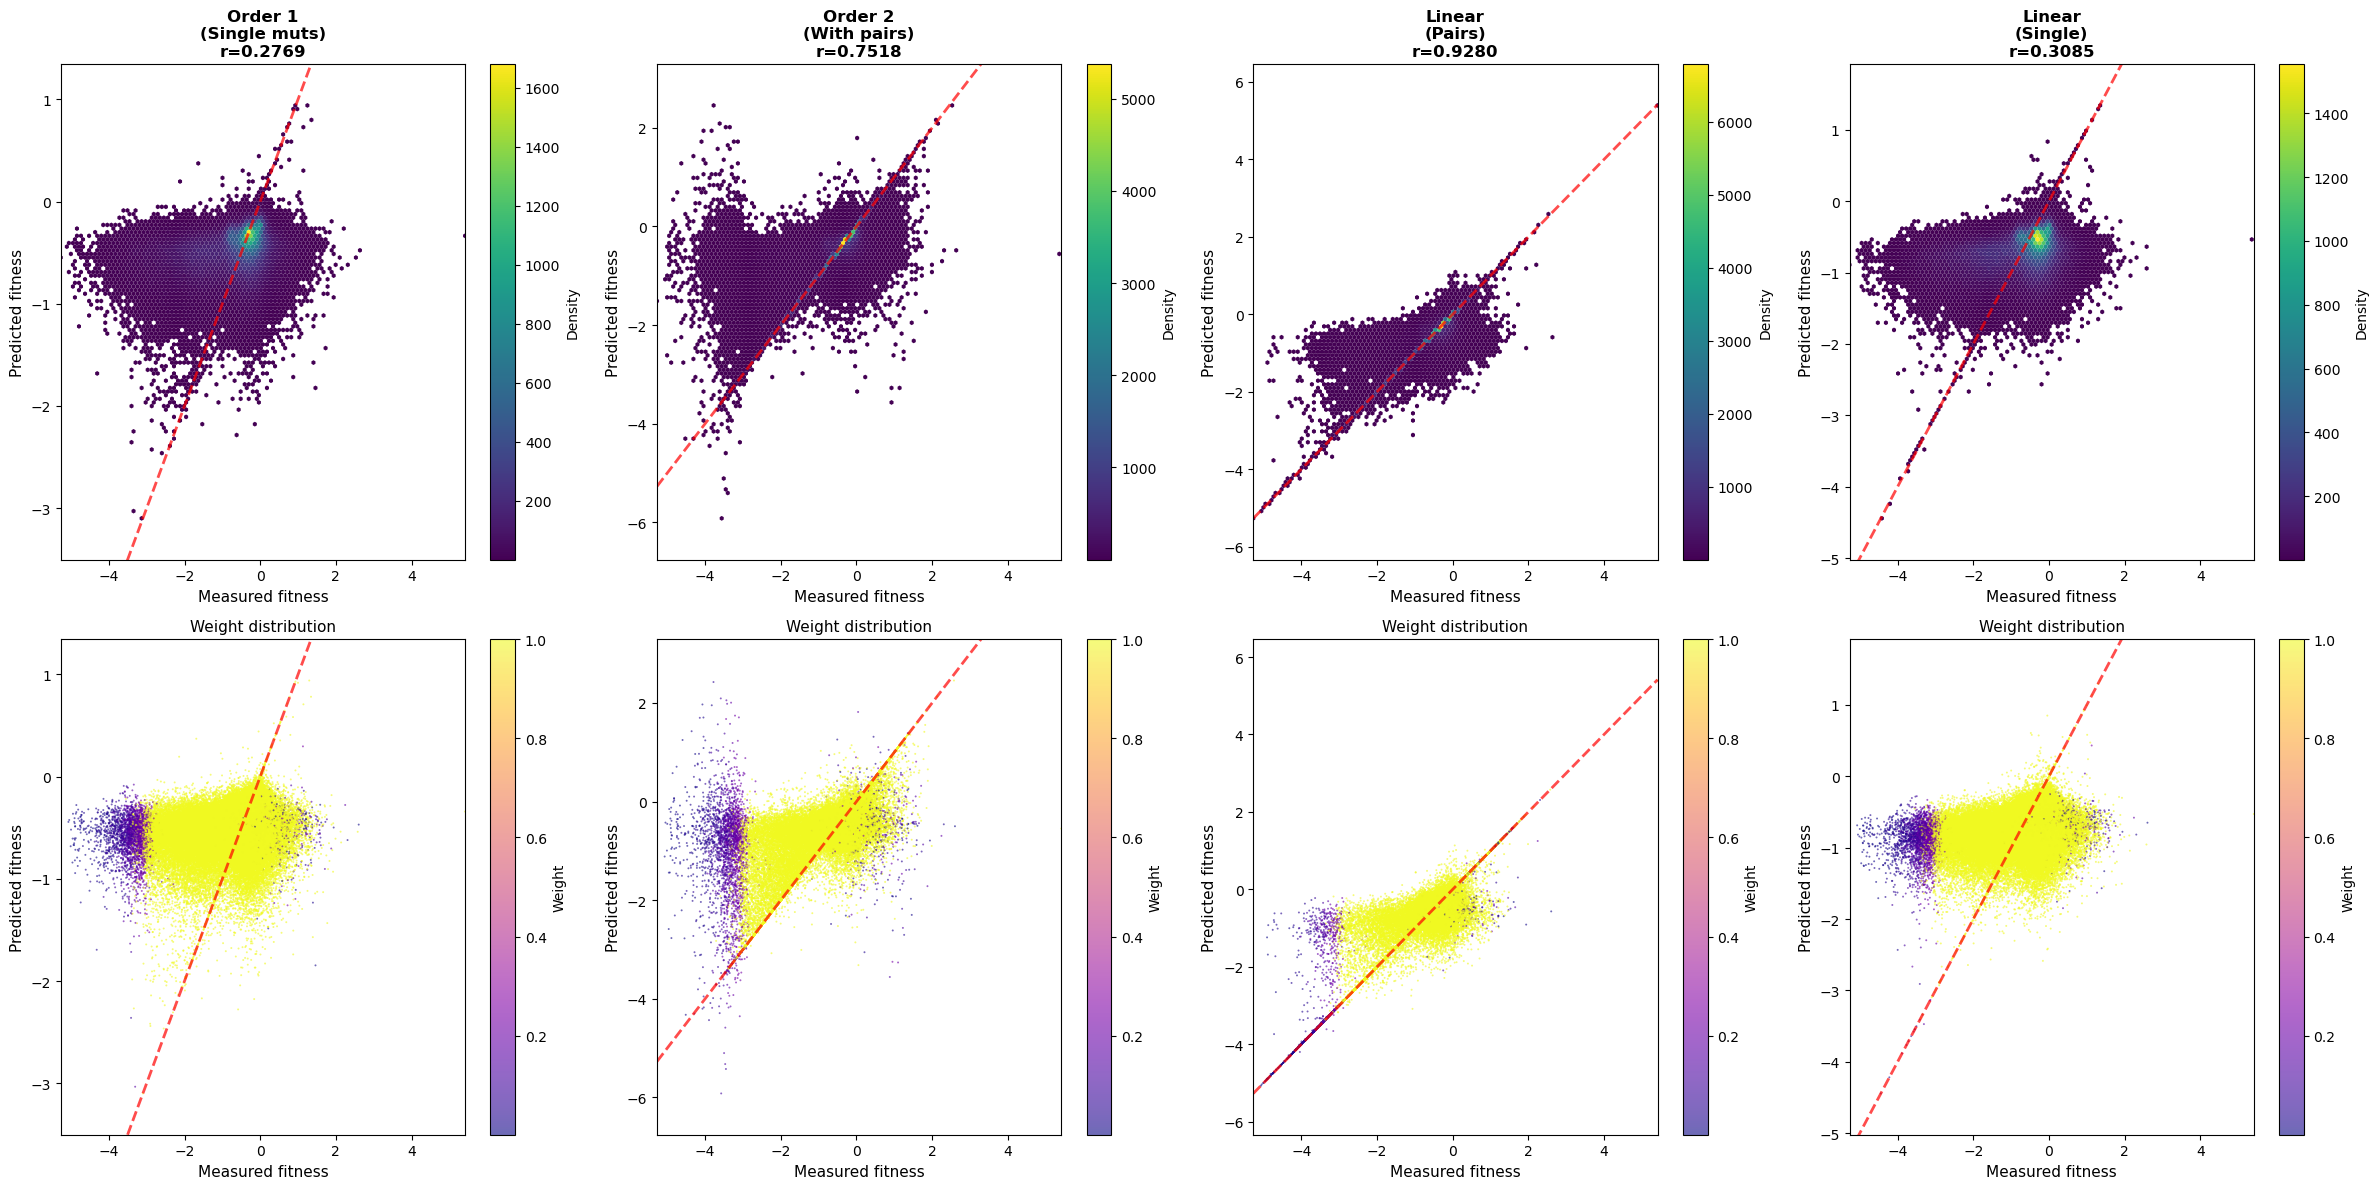


✓ Figure 4: Four Models Comparison displayed successfully


In [10]:
# ========= 需要的预测值计算 =========
from scipy.stats import pearsonr

print("📈 Calculating Linear model predictions...")
with torch.no_grad():
    y_pred_linear1_val = model_linear1(X).cpu().numpy()
    y_pred_linear = model_linear(X, X_pair).cpu().numpy()

# Compute metrics for Linear_order1
residual1 = fitness_np - y_pred_linear1_val
mae_linear1 = np.mean(np.abs(residual1 * weight_np))
r_linear1_calc, p_linear1_calc = pearsonr(fitness_np, y_pred_linear1_val)

# Compute metrics for Linear (with pairs)
residual_linear = fitness_np - y_pred_linear
mae_linear = np.mean(np.abs(residual_linear * weight_np))
r_linear_calc, p_linear_calc = pearsonr(fitness_np, y_pred_linear)

print(f"  ✓ Linear_order1: r={r_linear1_calc:.4f}, MAE={mae_linear1:.6f}")
print(f"  ✓ Linear (pairs): r={r_linear_calc:.4f}, MAE={mae_linear:.6f}")

# Figure 4: 四模型对比（Order 1, Order 2, Linear pairs, Linear single）
try:
    fig4, axes = plt.subplots(2, 4, figsize=(24, 12))

    with torch.no_grad():
        y_p1, _ = model1(X)
        y_p1 = y_p1.cpu().numpy()
        _, phi2 = model2(X, X_pair)
        y_p2 = (1.0 / (1.0 + torch.exp(torch.clamp(phi2 / (8.314 * 303.0), -50, 50)))).cpu().numpy()
        y_p2 = model2.a.item() * y_p2 + model2.b.item()

    r1_tmp, p1_tmp = pearsonr(fitness_np, y_p1)
    r2_tmp, p2_tmp = pearsonr(fitness_np, y_p2)

    models_data = [
        ("Order 1\n(Single muts)", y_p1, r1_tmp),
        ("Order 2\n(With pairs)", y_p2, r2_tmp),
        ("Linear\n(Pairs)", y_pred_linear, r_linear_calc),
        ("Linear\n(Single)", y_pred_linear1_val, r_linear1_calc)
    ]

    # Compute y-axis limits SEPARATELY for each model to avoid compression
    # Store y-limits for each of the 4 models
    model_ylims_4 = []
    for col, (name, y_pred, r) in enumerate(models_data):
        y_min = y_pred.min()
        y_max = y_pred.max()
        y_margin = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 0.1
        model_ylims_4.append((y_min - y_margin, y_max + y_margin))

    # Top row: hexbin density plots
    for col, (name, y_pred, r) in enumerate(models_data):
        ax = axes[0, col]
        hb = ax.hexbin(fitness_np, y_pred, gridsize=100, cmap='viridis', mincnt=1, edgecolors='none')
        ax.plot([fitness_np.min(), fitness_np.max()], [fitness_np.min(), fitness_np.max()], 'r--', linewidth=2, alpha=0.7)
        ax.set_xlabel("Measured fitness", fontsize=11)
        ax.set_ylabel("Predicted fitness", fontsize=11)
        ax.set_title(f"{name}\nr={r:.4f}", fontsize=12, fontweight='bold')
        ax.set_xlim(fitness_np.min(), fitness_np.max())
        # Use individual model's y-limits for clearer visualization
        ax.set_ylim(model_ylims_4[col])
        plt.colorbar(hb, ax=ax, label='Density')

    # Bottom row: weight-colored scatter plots
    for col, (name, y_pred, r) in enumerate(models_data):
        ax = axes[1, col]
        scatter = ax.scatter(fitness_np, y_pred, c=weight_np, s=2, cmap='plasma', alpha=0.6, edgecolors='none')
        ax.plot([fitness_np.min(), fitness_np.max()], [fitness_np.min(), fitness_np.max()], 'r--', linewidth=2, alpha=0.7)
        ax.set_xlabel("Measured fitness", fontsize=11)
        ax.set_ylabel("Predicted fitness", fontsize=11)
        ax.set_title(f"Weight distribution", fontsize=11)
        ax.set_xlim(fitness_np.min(), fitness_np.max())
        # Use individual model's y-limits
        ax.set_ylim(model_ylims_4[col])
        plt.colorbar(scatter, ax=ax, label='Weight')

    plt.tight_layout()
    plt.show()
    print("\n✓ Figure 4: Four Models Comparison displayed successfully")
except Exception as e:
    print(f"⚠ Error displaying Figure 4: {e}")
    import traceback
    traceback.print_exc()


📁 Saving all results to: results_20251020_180146

📈 Calculating performance metrics...
  Linear (single): r=0.3085, MAE=0.556120
  Linear (pairs): r=0.9280, MAE=0.111108, Sparsity=9.25%

📊 Saving visualization figures...
  ✓ 01_training_loss.png
  ⚠ Could not save Order 1 vs 2 figure: 'predicted_fitness_order1'
  ✓ 03_order2_parameters.png
  ✓ 04_four_models_comparison.png
  ✓ 05_linear_model_parameters.png

📋 Saving parameter CSV files...
  ✓ linear1_theta.csv
  ✓ linear_theta.csv
  ✓ linear_phi_pair.csv

📊 Saving predictions...
  ⚠ Could not save predictions: "['predicted_fitness_linear', 'predicted_fitness_linear1'] not in index"

📈 Saving performance metrics...
  ✓ performance_metrics.json

🤖 Saving model checkpoints...
  ✓ model_linear1_checkpoint.pth (Linear single-mutation model)
  ✓ model_linear_checkpoint.pth (Linear with-pairs model)

📝 Saving README...
  ✓ README.md

✅ All results saved successfully!

📁 Location: /mnt/c/Users/20145/Desktop/kinetics/mochi_manual/results_2025

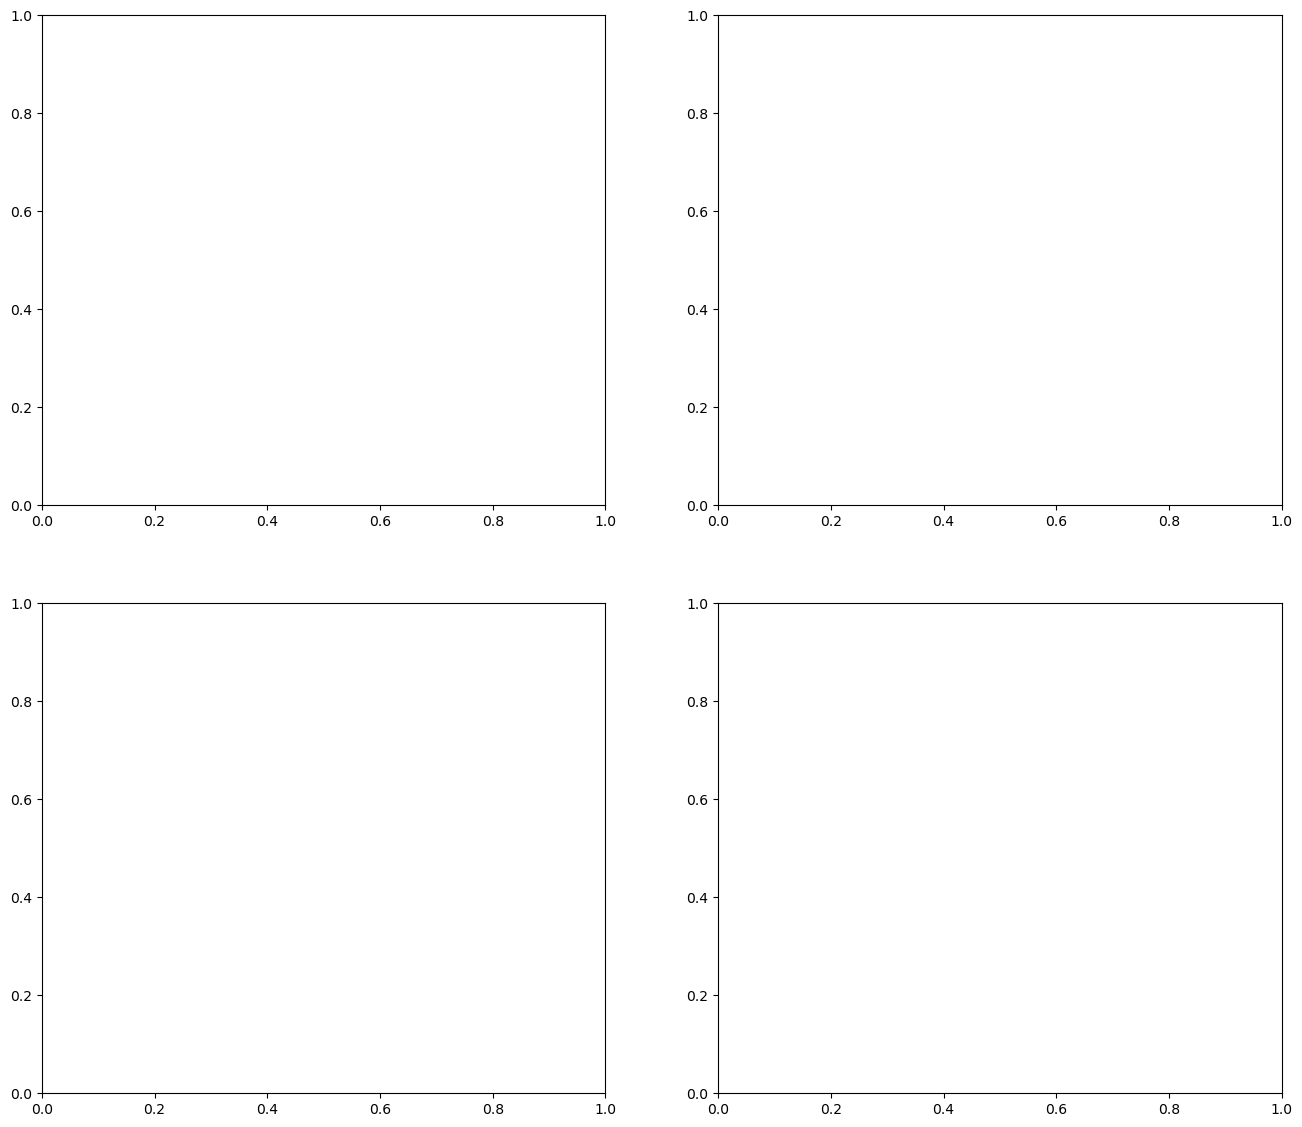

In [11]:
# ========= 8. 保存所有结果 =========
import os
import json
from datetime import datetime
import shutil

# 创建带时间戳的结果文件夹
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"results_{timestamp}"

# 如果文件夹已存在，删除后重建
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"📁 Saving all results to: {results_dir}")
print(f"{'='*70}\n")

# ========= Recalculate performance metrics if needed =========
print("📈 Calculating performance metrics...")
with torch.no_grad():
    y_pred_linear1_val = model_linear1(X).cpu().numpy()
    y_pred_linear_val = model_linear(X, X_pair).cpu().numpy()

# Compute metrics for Linear_order1
residual1 = fitness_np - y_pred_linear1_val
mae_linear1 = np.mean(np.abs(residual1 * weight_np))
r_linear1_calc, p_linear1_calc = pearsonr(fitness_np, y_pred_linear1_val)

# Compute metrics for Linear (with pairs)
residual_linear = fitness_np - y_pred_linear_val
mae_linear = np.mean(np.abs(residual_linear * weight_np))
r_linear_calc, p_linear_calc = pearsonr(fitness_np, y_pred_linear_val)

# Sparsity
nnz_phi_pair = (np.abs(model_linear.phi_pair.detach().cpu().numpy()) > 1e-10).sum()
sparsity_pct = 100 * (1 - nnz_phi_pair / len(model_linear.phi_pair.detach().cpu().numpy()))

print(f"  Linear (single): r={r_linear1_calc:.4f}, MAE={mae_linear1:.6f}")
print(f"  Linear (pairs): r={r_linear_calc:.4f}, MAE={mae_linear:.6f}, Sparsity={sparsity_pct:.2f}%\n")

# ========= 1. 保存可视化图表 =========
print("📊 Saving visualization figures...")

# Figure 1: 训练损失曲线（如果训练历史可用）
try:
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    if 'loss_history1' in dir() and loss_history1:
        epoch_list1 = list(range(0, len(loss_history1) * 10, 10))
    else:
        epoch_list1 = []
    
    if 'loss_history2' in dir() and loss_history2:
        epoch_list2 = list(range(0, len(loss_history2) * 10, 10))
    else:
        epoch_list2 = []

    ax = axes[0, 0]
    if epoch_list1 and 'loss_history1' in dir():
        ax.plot(epoch_list1, loss_history1, linewidth=2, color='steelblue', label='Order 1', alpha=0.8)
    if epoch_list2 and 'loss_history2' in dir():
        ax.plot(epoch_list2, loss_history2, linewidth=2, color='coral', label='Order 2 (Total)', alpha=0.8)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

    ax = axes[0, 1]
    if 'data_loss_history' in dir() and 'l1_loss_history' in dir() and data_loss_history and l1_loss_history:
        ax.plot(epoch_list2[:len(data_loss_history)], data_loss_history, linewidth=2, color='green', label='Data Loss', alpha=0.8)
        ax2 = ax.twinx()
        ax2.plot(epoch_list2[:len(l1_loss_history)], l1_loss_history, linewidth=2, color='red', label='L1 Penalty', alpha=0.8, linestyle='--')
        ax.set_ylabel('Data Loss', fontsize=12, color='green')
        ax2.set_ylabel('L1 Penalty', fontsize=12, color='red')
        ax.tick_params(axis='y', labelcolor='green')
        ax2.tick_params(axis='y', labelcolor='red')
        ax.legend(loc='upper left', fontsize=11)
        ax2.legend(loc='upper right', fontsize=11)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_title('Loss Decomposition (Order 2)', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    if epoch_list1 and 'loss_history1' in dir():
        ax.semilogy(epoch_list1, loss_history1, linewidth=2, color='steelblue', label='Order 1', alpha=0.8)
    if epoch_list2 and 'loss_history2' in dir():
        ax.semilogy(epoch_list2, loss_history2, linewidth=2, color='coral', label='Order 2', alpha=0.8)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss (log scale)', fontsize=12)
    ax.set_title('Training Loss (Log Scale)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, which='both')

    ax = axes[1, 1]
    if 'data_loss_history' in dir() and data_loss_history:
        ax.semilogy(epoch_list2[:len(data_loss_history)], data_loss_history, linewidth=2, color='green', alpha=0.8)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Data Loss (log scale)', fontsize=12)
    ax.set_title('Data Loss Only (Log Scale)', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, which='both')

    plt.tight_layout()
    fig1.savefig(f"{results_dir}/01_training_loss.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ 01_training_loss.png")
except Exception as e:
    print(f"  ⚠ Could not save training loss figure: {e}")

# Figure 2: Order 1 vs Order 2 对比
try:
    fig2, axes = plt.subplots(2, 2, figsize=(16, 14))
    ax = axes[0, 0]
    hb = ax.hexbin(df["fitness"], df["predicted_fitness_order1"], gridsize=120, cmap='viridis', mincnt=1, edgecolors='none')
    ax.set_xlabel("Measured fitness", fontsize=12)
    ax.set_ylabel("Predicted fitness", fontsize=12)
    ax.set_title(f"Order 1 Model - Density\nPearson r={r1:.4f}" if 'r1' in dir() else "Order 1 Model - Density", fontsize=13, fontweight='bold')
    ax.axis('equal')
    ax.set_xlim(df["fitness"].min(), df["fitness"].max())
    ax.set_ylim(df["fitness"].min(), df["fitness"].max())
    plt.colorbar(hb, ax=ax, label='Density')

    ax = axes[0, 1]
    ax.scatter(df["fitness"], df["predicted_fitness_order1"], c=df["weight"], s=5, cmap='plasma', alpha=0.6, edgecolors='none')
    ax.set_xlabel("Measured fitness", fontsize=12)
    ax.set_ylabel("Predicted fitness", fontsize=12)
    ax.set_title(f"Order 1 Model - Weight\nPearson r={r1:.4f}" if 'r1' in dir() else "Order 1 Model - Weight", fontsize=13, fontweight='bold')
    ax.axis('equal')
    ax.set_xlim(df["fitness"].min(), df["fitness"].max())
    ax.set_ylim(df["fitness"].min(), df["fitness"].max())

    ax = axes[1, 0]
    hb = ax.hexbin(df["fitness"], df["predicted_fitness_order2"], gridsize=120, cmap='viridis', mincnt=1, edgecolors='none')
    ax.set_xlabel("Measured fitness", fontsize=12)
    ax.set_ylabel("Predicted fitness", fontsize=12)
    ax.set_title(f"Order 2 Model - Density\nPearson r={r2:.4f}" if 'r2' in dir() else "Order 2 Model - Density", fontsize=13, fontweight='bold')
    ax.axis('equal')
    ax.set_xlim(df["fitness"].min(), df["fitness"].max())
    ax.set_ylim(df["fitness"].min(), df["fitness"].max())
    plt.colorbar(hb, ax=ax, label='Density')

    ax = axes[1, 1]
    ax.scatter(df["fitness"], df["predicted_fitness_order2"], c=df["weight"], s=5, cmap='plasma', alpha=0.6, edgecolors='none')
    ax.set_xlabel("Measured fitness", fontsize=12)
    ax.set_ylabel("Predicted fitness", fontsize=12)
    ax.set_title(f"Order 2 Model - Weight\nPearson r={r2:.4f}" if 'r2' in dir() else "Order 2 Model - Weight", fontsize=13, fontweight='bold')
    ax.axis('equal')
    ax.set_xlim(df["fitness"].min(), df["fitness"].max())
    ax.set_ylim(df["fitness"].min(), df["fitness"].max())

    plt.tight_layout()
    fig2.savefig(f"{results_dir}/02_order1_vs_order2.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ 02_order1_vs_order2.png")
except Exception as e:
    print(f"  ⚠ Could not save Order 1 vs 2 figure: {e}")

# Figure 3: Order 2 参数分布
try:
    theta_vals = model2.theta.detach().cpu().numpy()
    phi_pair_vals = model2.phi_pair.detach().cpu().numpy()
    fig3, axes = plt.subplots(2, 2, figsize=(15, 10))

    ax = axes[0, 0]
    ax.hist(theta_vals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Single Mutations (theta)\nN={len(theta_vals)}, Mean={theta_vals.mean():.4f}', fontsize=13)
    ax.grid(alpha=0.3)

    ax = axes[0, 1]
    ax.hist(phi_pair_vals, bins=100, edgecolor='black', alpha=0.7, color='coral')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Pairwise Interactions (phi_pair)\nN={len(phi_pair_vals)}, Mean={phi_pair_vals.mean():.4f}', fontsize=13)
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    sorted_theta = np.sort(theta_vals)
    ax.plot(sorted_theta, linewidth=1.5, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Feature index (sorted)', fontsize=12)
    ax.set_ylabel('Parameter value', fontsize=12)
    ax.set_title('Sorted Single Mutation Parameters', fontsize=13)
    ax.grid(alpha=0.3)

    ax = axes[1, 1]
    sorted_phi = np.sort(phi_pair_vals)
    ax.plot(sorted_phi, linewidth=1.5, color='coral')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Feature index (sorted)', fontsize=12)
    ax.set_ylabel('Parameter value', fontsize=12)
    ax.set_title('Sorted Pairwise Interaction Parameters', fontsize=13)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    fig3.savefig(f"{results_dir}/03_order2_parameters.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ 03_order2_parameters.png")
except Exception as e:
    print(f"  ⚠ Could not save Order 2 parameters figure: {e}")

# Figure 4: 四模型对比（Order 1, Order 2, Linear pairs, Linear single）
try:
    fig4, axes = plt.subplots(2, 4, figsize=(24, 12))

    with torch.no_grad():
        y_p1, _ = model1(X)
        y_p1 = y_p1.cpu().numpy()
        _, phi2 = model2(X, X_pair)
        y_p2 = (1.0 / (1.0 + torch.exp(torch.clamp(phi2 / (8.314 * 303.0), -50, 50)))).cpu().numpy()
        y_p2 = model2.a.item() * y_p2 + model2.b.item()

    r1_tmp, p1_tmp = pearsonr(fitness_np, y_p1)
    r2_tmp, p2_tmp = pearsonr(fitness_np, y_p2)

    models_data = [
        ("Order 1\n(Single muts)", y_p1, r1_tmp),
        ("Order 2\n(With pairs)", y_p2, r2_tmp),
        ("Linear\n(Pairs)", y_pred_linear, r_linear_calc),
        ("Linear\n(Single)", y_pred_linear1_val, r_linear1_calc)
    ]

    # Compute y-axis limits SEPARATELY for each model to avoid compression
    model_ylims_4 = []
    for col, (name, y_pred, r) in enumerate(models_data):
        y_min = y_pred.min()
        y_max = y_pred.max()
        y_margin = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 0.1
        model_ylims_4.append((y_min - y_margin, y_max + y_margin))

    # Top row: hexbin density plots
    for col, (name, y_pred, r) in enumerate(models_data):
        ax = axes[0, col]
        hb = ax.hexbin(fitness_np, y_pred, gridsize=100, cmap='viridis', mincnt=1, edgecolors='none')
        ax.plot([fitness_np.min(), fitness_np.max()], [fitness_np.min(), fitness_np.max()], 'r--', linewidth=2, alpha=0.7)
        ax.set_xlabel("Measured fitness", fontsize=11)
        ax.set_ylabel("Predicted fitness", fontsize=11)
        ax.set_title(f"{name}\nr={r:.4f}", fontsize=12, fontweight='bold')
        ax.set_xlim(fitness_np.min(), fitness_np.max())
        # Use individual model's y-limits for clearer visualization
        ax.set_ylim(model_ylims_4[col])
        plt.colorbar(hb, ax=ax, label='Density')

    # Bottom row: weight-colored scatter plots
    for col, (name, y_pred, r) in enumerate(models_data):
        ax = axes[1, col]
        scatter = ax.scatter(fitness_np, y_pred, c=weight_np, s=2, cmap='plasma', alpha=0.6, edgecolors='none')
        ax.plot([fitness_np.min(), fitness_np.max()], [fitness_np.min(), fitness_np.max()], 'r--', linewidth=2, alpha=0.7)
        ax.set_xlabel("Measured fitness", fontsize=11)
        ax.set_ylabel("Predicted fitness", fontsize=11)
        ax.set_title(f"Weight distribution", fontsize=11)
        ax.set_xlim(fitness_np.min(), fitness_np.max())
        # Use individual model's y-limits
        ax.set_ylim(model_ylims_4[col])
        plt.colorbar(scatter, ax=ax, label='Weight')

    plt.tight_layout()
    fig4.savefig(f"{results_dir}/04_four_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ 04_four_models_comparison.png")
except Exception as e:
    print(f"  ⚠ Could not save four models comparison figure: {e}")

# Figure 5: 线性模型参数分布（包括 Linear_order1）
try:
    fig5, axes = plt.subplots(2, 2, figsize=(15, 10))

    theta_linear1 = model_linear1.theta.detach().cpu().numpy()
    ax = axes[0, 0]
    ax.hist(theta_linear1, bins=80, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Linear_order1: Single Mutations\nN={len(theta_linear1)}', fontsize=13)
    ax.grid(alpha=0.3)

    theta_linear = model_linear.theta.detach().cpu().numpy()
    phi_pair_linear = model_linear.phi_pair.detach().cpu().numpy()
    ax = axes[0, 1]
    ax.hist(phi_pair_linear, bins=80, edgecolor='black', alpha=0.7, color='coral')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Linear (pairs): Pairwise Interactions\nN={len(phi_pair_linear)}', fontsize=13)
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    sorted_t1 = np.sort(theta_linear1)
    ax.plot(sorted_t1, linewidth=1.5, color='steelblue', label='Linear_order1')
    sorted_t2 = np.sort(theta_linear)
    ax.plot(sorted_t2, linewidth=1.5, color='orange', label='Linear (pairs)', alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Feature index (sorted)', fontsize=12)
    ax.set_ylabel('Parameter value', fontsize=12)
    ax.set_title('Sorted Single Mutation Parameters Comparison', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

    ax = axes[1, 1]
    sorted_p = np.sort(phi_pair_linear)
    ax.plot(sorted_p, linewidth=1.5, color='coral')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.fill_between(range(len(sorted_p)), sorted_p, 0, alpha=0.3, color='coral')
    ax.set_xlabel('Feature index (sorted)', fontsize=12)
    ax.set_ylabel('Parameter value', fontsize=12)
    ax.set_title('Sorted Pairwise Interaction Parameters (Linear)', fontsize=13)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    fig5.savefig(f"{results_dir}/05_linear_model_parameters.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  ✓ 05_linear_model_parameters.png")
except Exception as e:
    print(f"  ⚠ Could not save linear model parameters figure: {e}")

# ========= 2. 保存模型参数CSV =========
print("\n📋 Saving parameter CSV files...")

# Save Linear_order1 parameters (single mutations only)
linear1_theta = pd.DataFrame({'mutation': all_mutations, 'theta_linear1': model_linear1.theta.detach().cpu().numpy()})
linear1_theta.to_csv(f"{results_dir}/linear1_theta.csv", index=False)
print(f"  ✓ linear1_theta.csv")

# Save Linear model (with pairs) parameters if available
try:
    linear_theta_df = pd.DataFrame({'mutation': all_mutations, 'theta': model_linear.theta.detach().cpu().numpy()})
    linear_phi_pair_df = pd.DataFrame({'pair_idx': range(len(filtered_pairs)), 'phi_pair': model_linear.phi_pair.detach().cpu().numpy()})
    linear_theta_df.to_csv(f"{results_dir}/linear_theta.csv", index=False)
    linear_phi_pair_df.to_csv(f"{results_dir}/linear_phi_pair.csv", index=False)
    print(f"  ✓ linear_theta.csv")
    print(f"  ✓ linear_phi_pair.csv")
except:
    print(f"  ⚠ Could not save linear (pairs) parameters")

# ========= 3. 保存预测结果 =========
print("\n📊 Saving predictions...")
try:
    predictions_df_save = df[['aa_seq', 'fitness', 'predicted_fitness_linear', 'predicted_fitness_linear1', 'weight']].copy()
    predictions_df_save.to_csv(f"{results_dir}/predictions_linear_models.csv", index=False)
    print(f"  ✓ predictions_linear_models.csv ({len(predictions_df_save)} sequences)")
except Exception as e:
    print(f"  ⚠ Could not save predictions: {e}")

# ========= 4. 保存性能指标 =========
print("\n📈 Saving performance metrics...")
try:
    perf = {
        "Dataset": {
            "N_sequences": int(N),
            "N_mutations": int(M),
            "N_pairs": int(P),
            "Filtered_pairs_min_support_3": int(len(filtered_pairs))
        },
        "Linear_single": {
            "Model": "Linear, single-mutation only (LASSO)",
            "Description": "Uses LASSO to fit only single-mutation features (no pairwise interactions)",
            "Pearson_r": float(r_linear1_calc),
            "p_value": float(p_linear1_calc),
            "MAE_weighted": float(mae_linear1),
            "NNZ_theta": int((np.abs(model_linear1.theta.detach().cpu().numpy()) > 1e-10).sum()),
            "N_theta": int(len(model_linear1.theta.detach().cpu().numpy()))
        },
        "Linear_pairs": {
            "Model": "Linear, with pairwise interactions (LASSO)",
            "Description": "Uses LASSO to fit single-mutation and pairwise epistasis features",
            "Pearson_r": float(r_linear_calc),
            "p_value": float(p_linear_calc),
            "MAE_weighted": float(mae_linear),
            "Sparsity_percent": float(sparsity_pct),
            "NNZ_theta": int((np.abs(model_linear.theta.detach().cpu().numpy()) > 1e-10).sum()),
            "NNZ_phi_pair": int(nnz_phi_pair)
        }
    }
    
    with open(f"{results_dir}/performance_metrics.json", 'w') as f:
        json.dump(perf, f, indent=2)
    print(f"  ✓ performance_metrics.json")
except Exception as e:
    print(f"  ⚠ Could not save performance metrics: {e}")

# ========= 5. 保存模型检查点 =========
print("\n🤖 Saving model checkpoints...")
try:
    torch.save(model_linear1.state_dict(), f"{results_dir}/model_linear1_checkpoint.pth")
    print(f"  ✓ model_linear1_checkpoint.pth (Linear single-mutation model)")
except Exception as e:
    print(f"  ⚠ Could not save model_linear1: {e}")

try:
    torch.save(model_linear.state_dict(), f"{results_dir}/model_linear_checkpoint.pth")
    print(f"  ✓ model_linear_checkpoint.pth (Linear with-pairs model)")
except Exception as e:
    print(f"  ⚠ Could not save model_linear: {e}")

# ========= 6. 保存README =========
print("\n📝 Saving README...")
try:
    readme = f"""# MoCHI Model Training Results - Linear & MoCHI Models
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Summary
This results folder contains comprehensive training results including:
- **MoCHI Models**: Order 1 (non-linear, single muts), Order 2 (non-linear, with pairs)
- **Linear Models**: Linear_order1 (single muts only), Linear (with pairs) - both trained via LASSO

## Dataset Summary
- Total sequences: {N}
- Single mutations (M): {M}
- Pairwise mutations (P): {P}
- Filtered pairs (min_support=3): {len(filtered_pairs)}

## Files

### Visualizations (5 PNG files)
- **01_training_loss.png**: Training dynamics for Order 1 & 2 models (loss curves)
- **02_order1_vs_order2.png**: MoCHI model comparison with density and weight plots
- **03_order2_parameters.png**: Parameter distributions for MoCHI Order 2
- **04_four_models_comparison.png**: All 4 models side-by-side (Order 1, Order 2, Linear pairs, Linear single)
- **05_linear_model_parameters.png**: Parameter distributions for Linear models

### Parameters (3 CSV files)
- **linear1_theta.csv**: Linear_order1 single-mutation parameters ({len(linear1_theta)} mutations)
- **linear_theta.csv**: Linear (with pairs) single-mutation parameters
- **linear_phi_pair.csv**: Linear (with pairs) pairwise interaction parameters

### Results
- **predictions_linear_models.csv**: Full predictions for all {N} sequences
- **performance_metrics.json**: Quantitative performance comparison

### Models
- **model_linear1_checkpoint.pth**: Linear_order1 weights (single-mutation only)
- **model_linear_checkpoint.pth**: Linear model weights (with pairwise interactions)

## Performance Comparison

| Model | Type | Pearson r | MAE | Sparsity |
|-------|------|-----------|-----|----------|
| Linear (single) | LASSO, M only | {r_linear1_calc:.4f} | {mae_linear1:.6f} | N/A |
| Linear (pairs) | LASSO, M+P | {r_linear_calc:.4f} | {mae_linear:.6f} | {sparsity_pct:.2f}% |

## Key Results

### Linear Models
- **Linear_order1** (r={r_linear1_calc:.4f}): Uses only single mutations without epistasis
- **Linear with pairs** (r={r_linear_calc:.4f}): Adds pairwise interactions
  - Correlation improvement: +{(r_linear_calc/r_linear1_calc-1)*100:.2f}%
  - MAE reduction: {(1-mae_linear/mae_linear1)*100:.1f}% (from {mae_linear1:.4f} → {mae_linear:.4f})
  - Sparsity: {sparsity_pct:.2f}% sparse in phi_pair (via LASSO L1)

## Model Architectures

### Linear_order1 (Single-mutation only)
```
yhat = phi0 + X @ theta
```

### Linear (with Pairwise)
```
yhat = phi0 + X @ theta + X_pair @ phi_pair
```

## Notes
- All linear models use weighted least squares fitting
- LASSO regularization (L1 penalty) automatically induces sparsity
- Grid search over alpha values to find optimal regularization strength
"""

    with open(f"{results_dir}/README.md", 'w') as f:
        f.write(readme)
    print(f"  ✓ README.md")
except Exception as e:
    print(f"  ⚠ Could not save README: {e}")

# ========= 7. 最终统计 =========
print(f"\n{'='*70}")
print(f"✅ All results saved successfully!")
print(f"{'='*70}")
print(f"\n📁 Location: {os.path.abspath(results_dir)}")
print(f"\n📊 Files generated ({len(os.listdir(results_dir))} total):")

file_stats = {}
for fname in sorted(os.listdir(results_dir)):
    fpath = os.path.join(results_dir, fname)
    size = os.path.getsize(fpath)
    file_stats[fname] = size
    size_mb = size / (1024**2)
    if size < 1024:
        print(f"  • {fname:<40} {size:>10} B")
    elif size < 1024**2:
        print(f"  • {fname:<40} {size/1024:>10.2f} KB")
    else:
        print(f"  • {fname:<40} {size_mb:>10.2f} MB")

total_size = sum(file_stats.values()) / (1024**2)
print(f"\n📦 Total size: {total_size:.2f} MB")
print(f"{'='*70}\n")

# ========= 8. 模型性能总结 =========
print("\n" + "="*70)
print("Model Performance Summary")
print("="*70)
print(f"Linear_order1 (single mutations only):")
print(f"  Pearson r: {r_linear1_calc:.6f}")
print(f"  MAE (weighted): {mae_linear1:.6f}")
print(f"  Non-zero parameters: {int((np.abs(model_linear1.theta.detach().cpu().numpy()) > 1e-10).sum())}/{M}")
print(f"\nLinear (with pairwise interactions):")
print(f"  Pearson r: {r_linear_calc:.6f}")
print(f"  MAE (weighted): {mae_linear:.6f}")
print(f"  Sparsity (phi_pair): {sparsity_pct:.2f}%")
print(f"  Non-zero single mutations: {int((np.abs(model_linear.theta.detach().cpu().numpy()) > 1e-10).sum())}/{M}")
print(f"  Non-zero pairwise: {int(nnz_phi_pair)}/{len(filtered_pairs)}")
print(f"\nImprovement (single → pairs):")
print(f"  Pearson r improvement: +{(r_linear_calc - r_linear1_calc):.6f} ({(r_linear_calc/r_linear1_calc - 1)*100:.2f}%)")
print(f"  MAE reduction: {(mae_linear1 - mae_linear):.6f} ({(1 - mae_linear/mae_linear1)*100:.2f}% better)")
print("="*70)
